In [1]:
import pandas as pd
import numpy as np
import tensorflow.keras.models as models
import tensorflow.keras
import matplotlib.pyplot as plt
import matplotlib.colors
import neighdist
import itertools
import pickle
import re

'''
# Configuración de los parámetros de matplotlib
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['font.size'] = 15
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.figsize'] = (7.2,4.45)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 17
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 6
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
'''

cmap = plt.cm.get_cmap('RdYlBu')
norm = matplotlib.colors.BoundaryNorm(np.arange(0,1.1,0.1), cmap.N)

C:\Users\igofo\AppData\Local\Temp\ipykernel_15812\687480769.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlBu')


### 1. Loading data

#### 1.1 Loading auxiliary data

In [2]:
"""An auxiliary file used to compute the features needed by the ANN"""
datos = pd.read_csv('datosrahm.csv')

maindict = {}
for row in range(datos.shape[0]):
    maindict[datos['Symbol'][row]] = \
    datos.iloc[row,:][['elecPau','atradrahm']].values

elemental_masses = np.load('element_masses.npy', allow_pickle=True).item()

#### 1.2 Loading the trained ANN and the standarization parameters

In [3]:
"""THE ARTIFICIAL NEURAL NETWORK IS LOADED AS WELL AS THE PARAMETERS TO DO THE FEATURE STANDARIZATION"""
directorio = 'best_ANN_multiclass/'
model_dict = np.load(directorio + '4S4O_WD-diccio.npy', allow_pickle=True).item()
model = models.load_model(directorio + '4S4O_WD.h5')

#### 1.3 Definition of the occupied sites in an aristotype perovskite

In [4]:
"""Occupied sites in an aristotype perovskite"""

wyckcub = {0:{'A' : np.asarray([[0.0,0.0,0.0]])},
          1:{'B' : np.asarray([[0.5,0.5,0.5]])},
          2:{'X' : np.asarray([[0.5,0.5,0.0],[0.5,0.0,0.5],[0.0,0.5,0.5]])}}

### 2. Helping functions

Here we have a set o auxiliary functions to compute the features and scan the different material proposals with the ANN.

In [5]:
def compute_quotients(X = np.zeros((1,1,2))):
    """
    Returns the atomic radii pair quotients and the atomic radii 
    pair sum - quotients as a numpy array. Thjs is the first part of
    all the features used to train the ANNs
    Parameters:
        X: A numpy array, which is created with the function raw_features_extractor
    Returns:
        X: A numpy array of dimension [samples,1,features]
    """
    
    rad = X[:,:,1]

    X = np.reshape(X,(X.shape[0],1,X.shape[1]*X.shape[2]))

    drad = np.asarray([[item[0]/item[1] if item[1] != 0 else 0 for item in list(itertools.combinations(rad[sample],2))] \
                        for sample in range(X.shape[0])])

    dradsum = np.asarray([[item[0]/item[1] if item[1] != 0 else 0 for item in itertools.combinations([ \
                       item[0]+item[1] for item in list(itertools.combinations(rad[sample],2))], 2)] \
                       for sample in range(drad.shape[0])])
    
    drad = np.reshape(drad,(drad.shape[0],1,drad.shape[-1]))
    drads = np.reshape(dradsum,(dradsum.shape[0],1,dradsum.shape[-1]))

    X = np.concatenate((drad,drads), axis=2)
        
    return X

def density(elements = [['Ca'],['Ti'], ['Te']], 
            compositions = [[1.0], [1.0],[1.0]],
            multiplicities = [[1],[1],[3]],
            angles = [90,90,90], 
            abc = [5,5,5]):
    """
    Computes the density of a compound based on its composition and unit cell parameters.
    Parameters:

        elements: List of lists containing atomic symbols
        compositions: List of lists with occupancy fractions
        multiplicities: List of lists with site multiplicities
        angles: List of three angles (in degrees) of the unit cell
        abc: List of three lattice parameters
    Returns:
        Density in g/cm³
    """    
    
    em = [[elemental_masses.get(elemento,None) for elemento in item] for item in elements]
    masses = [sum([k*v for k,v in zip(i,j)]) for i,j in zip(em, compositions)]
    zm = [i*j[0] for i,j  in zip(masses, multiplicities)]
    zm = sum(zm)/(6.022*10**23)

    volumen=abc[0]*abc[1]*abc[2]*np.sqrt(1-(np.cos(np.deg2rad(angles[0])))**2 - \
               (np.cos(np.deg2rad(angles[1])))**2-(np.cos(np.deg2rad(angles[2])))**2 + \
               2*np.cos(np.deg2rad(angles[0]))*np.cos(np.deg2rad(angles[1]))*np.cos(np.deg2rad(angles[2])))
    
    return (zm*10**24)/volumen

In [6]:
def scan_nnoutputs(elements = [['Ca'],['Ti'], ['S']], wef=False,
                   compositions = [[1.0], [1.0],[1.0]], 
                   maxdev = 0.2, stepsize=0.01,
                   sitios = 6, idx=7):
    """
    This is the main simulation function that uses the ANN to predict perovskite formation 
    probabilities across a range of lattice parameters.
    Simulates perovskite formation probability for various lattice parameters.
    Parameters:
        elements: List of lists specifying atoms in each site
        compositions: List of lists with occupancy fractions
        maxdev: Maximum deviation from calculated lattice parameter (default 0.2)
        stepsize: Step size for lattice parameter scan (default 0.01)
        sitios: Number of sites (default 6)
        idx: Index for selecting probability output (default 7)
        wef: Boolean to include additional features (default False)
    Returns:
        scanned_latpar: Array of scanned lattice parameters
        probabilities: Array of corresponding probabilities
    """
    
    scann = np.arange(1 - maxdev, 1 + maxdev + stepsize, stepsize)
    
    multiplicities = [[1],[1],[3]]

    sidx = [np.asarray(i)*np.asarray(j) for i,j in zip(compositions, multiplicities)]
    sidx = [k for h in sidx for k in h]
    
    elements2 = [k for j in elements for k in j]
    formula = [i + '$_{' + "%.2f" % j + '}$' for i,j in zip(elements2, sidx)]
    formula = ''.join([i for i in formula])
    
    primfeat = [np.dot(np.asarray(subind), np.asarray([maindict.get(item,None) \
              for item in site])) for site, subind in zip (elements, compositions)]
    
    primfeat = np.asarray(primfeat)
    
    while primfeat.shape[0] != sitios:
        primfeat = np.concatenate((np.zeros((1,primfeat.shape[1])),primfeat), axis = 0)
    
    latpar = primfeat[2][1] + primfeat[3][1]
    multiplicities = np.asarray(multiplicities)
    
    primfeat = primfeat.reshape((1, primfeat.shape[0],primfeat.shape[1]))
    xgeom = compute_quotients(X=primfeat)

    if wef:
        xre = primfeat.reshape(primfeat.shape[0],1,primfeat.shape[1]*primfeat.shape[2])
        xgeom = np.concatenate((xre,xgeom), axis=2)
    
    scann = scann**3
    scanned_latpar = latpar*(scann**(1/3))    

    dist = 25
    
    radii = primfeat[:,:,1]
    
    elec = primfeat[:,:,0]
    elec = elec.reshape((sitios,1))
    
    delec = np.repeat(elec[:,np.newaxis],sitios,axis=2) - \
            np.repeat(elec[:,np.newaxis],sitios,axis=2).T
    delec = delec.reshape((delec.shape[0],delec.shape[2]))

    fr = np.zeros((len(scann),sitios,sitios-1))
    for item in range(len(scanned_latpar)):

        p, z, n, m = neighdist.positions(pos = wyckcub, 
                                        angles = [90,90,90], 
                                        abc = [scanned_latpar[item],]*3,
                                        dist = dist)
        r = neighdist.rij(mult=m,p=p,zero=z,
                          dist=dist, sites=sitios, radii = np.ravel(radii))
        
        temp = np.multiply(r,delec)
        temp = temp[~np.eye(temp.shape[0],
                      dtype=bool)].reshape(temp.shape[0],-1)
        fr[item] = temp
    fr = fr.reshape((fr.shape[0],1,fr.shape[1]*fr.shape[2]))
    
    xgeom = np.asarray((xgeom,)*len(scann))
    xgeom = xgeom.reshape((xgeom.shape[0],1,xgeom.shape[3]))
    x = np.concatenate((xgeom,fr), axis=2)

    if wef:
        densidad = density(elements = elements, compositions = compositions,
                           multiplicities = multiplicities, abc = np.asarray((scanned_latpar,)*3),
                           angles = [90,90,90])

        x = np.concatenate((x, densidad[:, np.newaxis, np.newaxis]), axis=2)

    xs = (x - model_dict['mean'])/model_dict['std']
    xs = xs.astype(np.float32)

    probabilities = model.predict(xs[:,0,:], verbose=False)
    return scanned_latpar, probabilities[:,idx]
    

In [7]:
def compare_compounds(formulas = list(), abx_probs = dict(), abx_latpar = dict()):
    
    """
    Auxiliary function to plot the computed ANN outputs.

    This function visualizes the probability of different compounds crystallizing
    as perovskites. It creates a plot with the computed probabilities and lattice
    parameters for each given formula.

    Parameters:
    -----------
    formulas : list
        A list of strings where each string represents a chemical formula. 

    Global Variables:
    -----------------
    abx_probs : dict
        A dictionary where keys are chemical formulas and values are arrays of 
        probabilities that the compounds will crystallize as perovskites.

    abx_latpar : dict
        A dictionary where keys are chemical formulas and values are arrays of 
        lattice parameters associated with the compounds.

    Returns:
    --------
    None

    This function does not return any values. It generates a plot showing the 
    probabilities and lattice parameters for each formula in the input list.
    """
    
    fig, axes = plt.subplots(nrows=len(formulas), ncols=1)

    cmap = plt.cm.get_cmap('RdYlBu')
    norm = matplotlib.colors.BoundaryNorm(np.arange(0,1.1,0.1), cmap.N)
    
    for ax, idx, formula in zip(axes.flat, np.arange(0, len(axes.flat),1), formulas):
        nombre = formula[:-1]
        todos = ax.imshow(abx_probs[formula][:,np.newaxis].T,cmap=cmap,norm = norm)
        
        parameter = abx_latpar[formula]

        parameter = ["%.4f" % parameter[i] for i in range(len(parameter)) if i%5 == 0]

        ax.set_title(nombre+'$_{3}$', fontsize= 16)
        ax.set_xticks(np.arange(0,41,5))
        ax.set_xticklabels(parameter, fontsize = 14)
        ax.set_xlabel('Lattice parameter in ' + '$\AA$', fontsize= 14)
        ax.set_xticks(np.arange(-0.5,41,1),minor=True)
        ax.set_yticks([])
        ax.grid(which='minor', color='black', linewidth = '0.50')
    cb = plt.colorbar(todos, cmap = cmap, norm = norm, ax = list(axes.ravel()), shrink = 0.75, 
                      orientation = 'vertical')
    cb.ax.tick_params(labelsize = 14)
    cb.set_label('Probability to crystallize as perovskite', fontsize = 14)
    plt.show()
    
    return 

### 3. Exploring the simulation capabilities

In [18]:
#El orden es [['A'], ['B'],['X']], que corresponde a [[cubo],[octa],[anion]]
formcomp = 'CaZr0.25Ti0.75O2.1'
elements = [['Ca'], ['Zr','Ti'],['O']]
compositions = [[1.0],[0.25, 0.75],[0.7]]

In [19]:
latpars, probs = scan_nnoutputs(elements=elements, compositions = compositions, sitios=4, idx=1, wef=True)

In [20]:
print(latpars, probs)

[3.4332   3.476115 3.51903  3.561945 3.60486  3.647775 3.69069  3.733605
 3.77652  3.819435 3.86235  3.905265 3.94818  3.991095 4.03401  4.076925
 4.11984  4.162755 4.20567  4.248585 4.2915   4.334415 4.37733  4.420245
 4.46316  4.506075 4.54899  4.591905 4.63482  4.677735 4.72065  4.763565
 4.80648  4.849395 4.89231  4.935225 4.97814  5.021055 5.06397  5.106885
 5.1498  ] [0.00116002 0.00103481 0.00093485 0.00084793 0.00077339 0.00071081
 0.00064149 0.00057611 0.00052904 0.00049178 0.00046015 0.00043363
 0.00041226 0.00039698 0.00038653 0.00037933 0.00037372 0.00036828
 0.00036211 0.00035518 0.00034732 0.00033978 0.00033325 0.00032877
 0.00032604 0.000326   0.00032798 0.00033229 0.00033819 0.0003464
 0.00035628 0.00036747 0.00037939 0.0003939  0.00041111 0.00043101
 0.00045408 0.00048039 0.00050919 0.0005402  0.00056998]


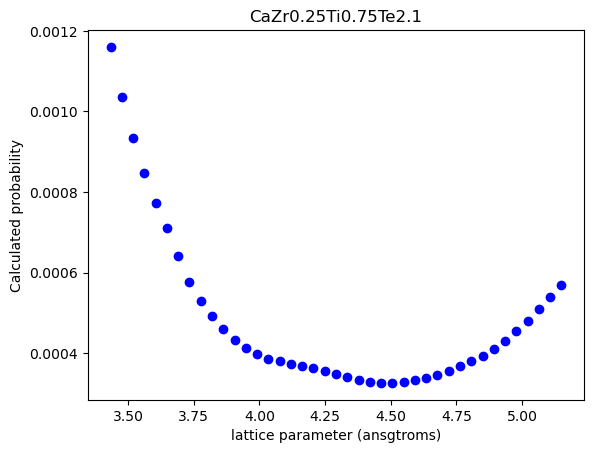

In [21]:
plt.figure()
plt.title(formcomp)
plt.scatter(latpars, probs, marker='o', color='blue')
plt.xlabel('lattice parameter (ansgtroms)')
plt.ylabel('Calculated probability')
plt.show()

#### 3.1 Exploring a set of single-compounds 

In [12]:
lista_compuestos = ['LiBeF3','LiBeCl3', 'LiBeBr3', 'LiBeI3', 'CsBeF3','CsBeCl3', 'CsBeBr3', 'CsBeI3']

abx_probs = dict()
abx_latpar = dict()
for formcomp in lista_compuestos:
    cubocta, octa, anion = re.findall('[A-Z][^A-Z]*', formcomp)
    anion = anion[:-1]
    elements = [[cubocta],[octa],[anion]]
    latpars, probs = scan_nnoutputs(elements=elements, sitios=4, idx=1, wef=True)
    abx_probs[formcomp] = probs
    abx_latpar[formcomp] = latpars

C:\Users\igofo\AppData\Local\Temp\ipykernel_15812\2673667306.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlBu')


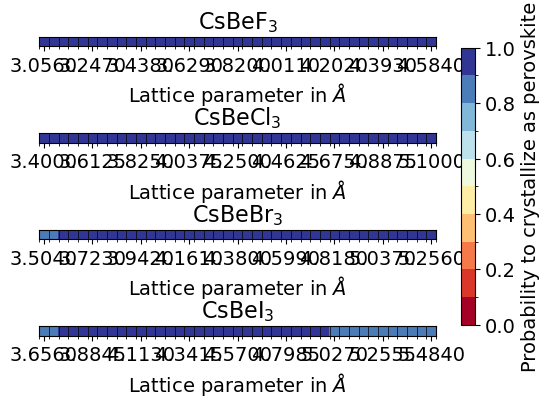

In [13]:
compare_compounds(['CsBeF3','CsBeCl3', 'CsBeBr3', 'CsBeI3'], abx_probs = abx_probs, abx_latpar=abx_latpar)

In [14]:
np.save('simulated_compounds_probs', abx_probs)
np.save('simulated_compounds_latpars', abx_latpar)

### 4. Solid solution exploration

In [15]:
elements = [['Ca'],['Ti','Zr'],['O','Te']]

In [16]:
stepcomp = 0.05
fracs = np.arange(0, 1 + stepcomp, stepcomp)

totalToCompute = fracs.shape[0]*fracs.shape[0]
print('Number of compositions to calculate:', totalToCompute)
c = 1
bidx = 0
for bfrac in fracs:
    xidx = 0
    for xfrac in fracs:
        compositions = [[1.0], [1.0 - bfrac, bfrac], [1.0 - xfrac, xfrac]]
        latpars, probs = scan_nnoutputs(elements=elements, compositions = compositions, sitios=4, idx=1, wef=True)

        if bidx == 0 and xidx == 0:
            latpararray = np.zeros((fracs.shape[0], fracs.shape[0], latpars.shape[0]))
            probarray = np.zeros((fracs.shape[0], fracs.shape[0], latpars.shape[0]))
        probarray[bidx, xidx] = probs
        latpararray[bidx, xidx] = latpars

        xidx += 1
    bidx += 1
    c += 1
    
    if c%10 == 0: print(c,'/', totalToCompute)

Number of compositions to calculate: 441
10 / 441
20 / 441


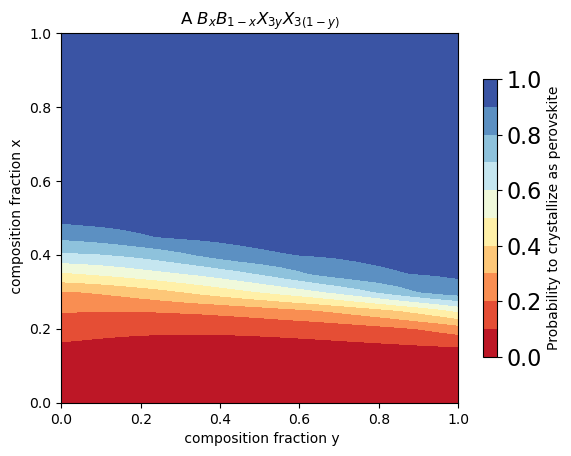

In [17]:
idxtotake = 0
y,x = np.meshgrid(1-fracs, 1-fracs)

fig, ax = plt.subplots()
cont = ax.contourf(x,y, probarray[:,:,idxtotake], levels = np.arange(0,1.1,0.1), cmap = 'RdYlBu')
plt.title(r'A $B_{x} B_{1-x} X_{3y} X_{3(1-y)}$')
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_label_position('bottom')
ax.set_xlim(0.0,1.0)
ax.set_xticks([i for i in np.arange(0,1.10,0.20)])

ax.set_xlabel(' composition fraction y')
ax.set_ylabel(' composition fraction x')

cb = plt.colorbar(cont,  shrink=0.75, orientation = 'vertical')
cb.ax.tick_params(labelsize = 16)      
cb.set_label('Probability to crystallize as perovskite')

plt.show()